# Проект: "Определение стоимости автомобилей"    
  
__Задача:__
- Подобрать модель, определяющую стоимость подержанных автомобилей.     
- Метрика RMSE < 2500.

__Целевые критерии:__
- качество предсказания;
- время обучения модели;
- время предсказания модели.  
 
__План:__
1. Подготовка к исследованию
2. Ознакомление с данными 
3. Минимальная обработка данных и формирование бейзлайн модели 
4. Итеративный процесс, подразумевающий на каждом этапе:
    - Обработка выбранных характеристик
    - Предсказание и оценка
5. Финальный вывод, рекомендации заказчику.  
  
__Акценты:__
1. В рамках исследования будут рассмотрены регрессионные модели: 
- LinearRegression  
- DecisionTreeRegressor  
- LightGBM  
2. Будет применена техника уменьшения занимаемой датасетом памяти 
3. Будет осуществлен перебор гиперпараметров с помощью RandomizedSearchCV


# Подготовка к исследованию

### Установки

In [1]:
# pip install shap -q

In [2]:
# pip install lightgbm -q

### Импорты

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import shap
import lightgbm as lgb

import warnings

### Настройки

In [4]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format','{:.1f}'.format)
shap.initjs()

PATH = 'Datasets/autos.csv'
RS = 888

regression = LinearRegression(n_jobs=-1)
tree = DecisionTreeRegressor(random_state=RS)
light = lgb.LGBMRegressor(random_state=RS, force_col_wise=True)

### Функции

In [5]:
def get_info():
    '''
     Возвращает основную информацию о датасете
     '''
    print(data.info(memory_usage='deep'))
    display(data.sample(5))
    print(f'Размер датасета: {data.shape}', end='\n\n')
    print(f'Полных дубликатов в датасете: {data.duplicated().sum()}', end='\n\n')
    print(f'Пропусков в датасете:\n{data.isna().sum()/data.shape[0] * 100}', end='\n\n')
    display(data.describe(include='all').T)
    
    
def renew():
    ''' 
    Сбрасывает датасет, форматирует имена признаков
    '''
    data = pd.read_csv(PATH)
    data.columns = data.columns.str.lower()
    return data


def power_subs(brand):
    '''
    Заменяет медианным значением мощности конкретной модели, соответствующей марки данные с мощностью <=10 л.с. 
    '''
    order = data.loc[(data['power'] > 10) & (data['brand'] == brand)]['model'].value_counts().index.to_list()
    for i in order:
        median = data.loc[(data['power'] > 10) & (data['brand'] == brand) & (data['model'] == i)]['power'].median()
        data.loc[(data['brand'] == brand) & (data['model'] == i) & (data['power'] <= 10), 'power'] = median

        
def memo_reductio(data, cat_features):
    '''
    Уменьшает количество используемой памяти для ускорения вычислений
    '''
    data.info(memory_usage='deep')
    data[cat_features] = data[cat_features].astype('category')
    int_types = data.select_dtypes(include=int).columns.to_list()
    data[int_types] = data[int_types].apply(pd.to_numeric, downcast='unsigned')
    try:
        float_types = data.select_dtypes(include=float).columns.to_list()
        data[float_types] = data[float_types].apply(pd.to_numeric, downcast='float')
    except:
        pass
    data.info(memory_usage='deep')
    return data


def fueltype_fill(brand):
    ''' 
    Заполняет тип топлива на самый частовстречающийся у данной модели данной марки
    '''
    order = data.loc[(data['brand'] == brand) & (~data['fueltype'].isna())]['model'].value_counts().index.to_list()
    for i in order:
        freq = data.loc[(data['brand'] == brand) & (data['model'] == i) & (~data['fueltype'].isna())]['fueltype'].max()
        data.loc[(data['brand'] == brand) & (data['model'] == i) & (data['fueltype'].isna()), 'fueltype'] = freq
    
    
def vehicletype_fill(brand):
    ''' 
    Заполняет тип авто на самый частовстречающийся у данной модели данной марки
    '''
    order = data.loc[(data['brand'] == brand) & (~data['vehicletype'].isna())]['model'].value_counts().index.to_list()
    for i in order:
        freq = data.loc[(data['brand'] == brand) & (data['model'] == i) & (~data['vehicletype'].isna())]['vehicletype'].max()
        data.loc[(data['brand'] == brand) & (data['model'] == i) & (data['vehicletype'].isna()), 'vehicletype'] = freq
        
        
def gearbox_fill(brand):
    ''' 
    Заполняет тип коробки на самый частовстречающийся у данной модели данной марки
    '''
    order = data.loc[(data['brand'] == brand) & (~data['gearbox'].isna())]['model'].value_counts().index.to_list()
    for i in order:
        freq = data.loc[(data['brand'] == brand) & (data['model'] == i) & (~data['gearbox'].isna())]['gearbox'].max()
        data.loc[(data['brand'] == brand) & (data['model'] == i) & (data['gearbox'].isna()), 'gearbox'] = freq

***

# Знакомство с датасетом


In [6]:
data = pd.read_csv(PATH)
get_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22659,2016-03-19 11:47:22,3999,bus,2004,auto,150,voyager,150000,7,gasoline,chrysler,no,2016-03-19 00:00:00,0,63607,2016-03-24 04:46:16
267664,2016-03-12 19:40:33,3950,NaN,1980,manual,60,other,70000,5,NaN,opel,no,2016-03-12 00:00:00,0,71272,2016-03-15 06:17:49
336442,2016-03-08 17:50:21,1400,small,2000,manual,60,fiesta,125000,12,petrol,ford,no,2016-03-08 00:00:00,0,35683,2016-03-10 14:29:32
305459,2016-03-07 21:55:35,350,small,1994,manual,55,punto,125000,5,petrol,fiat,NaN,2016-03-07 00:00:00,0,51674,2016-03-24 02:47:13
14283,2016-03-17 00:38:17,1600,small,2000,manual,101,fabia,150000,10,petrol,skoda,no,2016-03-16 00:00:00,0,42929,2016-04-06 01:16:05


Размер датасета: (354369, 16)

Полных дубликатов в датасете: 4

Пропусков в датасете:
DateCrawled          0.0
Price                0.0
VehicleType         10.6
RegistrationYear     0.0
Gearbox              5.6
Power                0.0
Model                5.6
Kilometer            0.0
RegistrationMonth    0.0
FuelType             9.3
Brand                0.0
Repaired            20.1
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.7,4514.2,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.2,90.2,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.1,189.9,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.2,37905.3,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.7,3.7,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Вывод  
- Занимает 217 мегабайт памяти  
- 16 признаков, более 300 тыс. объектов  
- Источник - немецкий авторынок  
- Есть полные дубликаты  
- В 5 признаках есть значительное количество пропусков

***

# Итерация №1  
Поверхностная обработка датасета без вникания в связи для построения бэйзлайн модели

### Предобработка

In [7]:
# Приведение названий к единому регистру
data.columns = data.columns.str.lower()

In [8]:
# Установка заглушек
data['repaired'] = data['repaired'].fillna('no_data')
data['gearbox'] = data['gearbox'].fillna('no_data')
data['fueltype'] = data['fueltype'].fillna('no_data')
data['vehicletype'] = data['vehicletype'].fillna('no_data')
data['model'] = data['model'].fillna('no_data')

In [9]:
# Удаление столбцов
data = data.drop(['numberofpictures', 'datecrawled', 'registrationmonth', 'datecreated', 'lastseen', 'power'], axis=1)

In [10]:
# Удаление полных и неполных дубликатов
data = data.drop_duplicates(keep='first').reset_index(drop=True)

In [11]:
# Обработка аномальных значений
data = data.query('price >= 200')
data = data.query('1950 < registrationyear <= 2016 ')
data = data.query('brand != "sonstige_autos"').reset_index(drop=True)

### Кодирование

In [12]:
# Уменьшение используемой памяти
cat_features = ['vehicletype', 'gearbox','model','fueltype','brand','repaired', 'kilometer']
memo_reductio(data, cat_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296831 entries, 0 to 296830
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             296831 non-null  int64 
 1   vehicletype       296831 non-null  object
 2   registrationyear  296831 non-null  int64 
 3   gearbox           296831 non-null  object
 4   model             296831 non-null  object
 5   kilometer         296831 non-null  int64 
 6   fueltype          296831 non-null  object
 7   brand             296831 non-null  object
 8   repaired          296831 non-null  object
 9   postalcode        296831 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 115.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296831 entries, 0 to 296830
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   price             296831 non-null  uint16  
 1   vehicletype

,price,vehicletype,registrationyear,gearbox,model,kilometer,fueltype,brand,repaired,postalcode
0,480,no_data,1993,manual,golf,150000,petrol,volkswagen,no_data,70435
1,18300,coupe,2011,manual,no_data,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,grand,125000,gasoline,jeep,no_data,90480
3,1500,small,2001,manual,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,fabia,90000,gasoline,skoda,no,60437
...,...,...,...,...,...,...,...,...,...,...
296826,5250,no_data,2016,auto,159,150000,no_data,alfa_romeo,no,51371
296827,3200,sedan,2004,manual,leon,150000,petrol,seat,yes,96465
296828,1199,convertible,2000,auto,fortwo,125000,petrol,smart,no,26135
296829,9200,bus,1996,manual,transporter,150000,gasoline,volkswagen,no,87439


In [13]:
# Разделение датасета на тренировочный и тестовый
features = data.drop('price', axis =1)
target = data['price']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            train_size=0.7,
                                                                            random_state=RS)
features_test, features_valid, target_test, target_valid = train_test_split(features_test, 
                                                                            target_test, 
                                                                            test_size=0.3, 
                                                                            random_state=RS)
print(f'Количество объектов:\nТренировочная - {features_train.shape[0]}')
print(f'Тестовая - {features_test.shape[0]}')
print(f'Валидационная - {features_valid.shape[0]}')

Количество объектов:
Тренировочная - 207781
Тестовая - 62335
Валидационная - 26715


In [14]:
# Кодирование номинативных переменных
ohe_encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
ohe_encoder.fit(features_train[cat_features])

features_train[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_train[cat_features])
features_train = features_train.drop(cat_features, axis=1)

features_test[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_test[cat_features])
features_test = features_test.drop(cat_features, axis=1)

features_valid[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_valid[cat_features])
features_valid = features_valid.drop(cat_features, axis=1)

print(f'Количество признаков:\nТренировочная - {features_train.shape[1]}')
print(f'Тестовая - {features_test.shape[1]}')
print(f'Валидационная - {features_valid.shape[1]}')

Количество признаков:
Тренировочная - 321
Тестовая - 321
Валидационная - 321


In [15]:
transformer = QuantileTransformer(output_distribution ='normal', random_state=RS)
features_train[['registrationyear', 'postalcode']] = transformer.fit_transform(features_train[['registrationyear', 'postalcode']])
features_test[['registrationyear', 'postalcode']] = transformer.transform(features_test[['registrationyear', 'postalcode']])
features_valid[['registrationyear', 'postalcode']] = transformer.transform(features_valid[['registrationyear', 'postalcode']])

In [16]:
del data
del features
del target

### Предсказание и оценка

In [17]:
%%time
# LinearRegression обучение
regression.fit(features_train, target_train)

CPU times: total: 23.5 s
Wall time: 3.84 s


LinearRegression(n_jobs=-1)

In [18]:
%%time
# LinearRegression предсказание
predicted = regression.predict(features_test)
print(mean_squared_error(target_test, predicted, squared=False))

2769.5090712999945
CPU times: total: 203 ms
Wall time: 82.1 ms


In [19]:
%%time
# DecisionTreeRegressor обучение
tree.fit(features_train, target_train)

CPU times: total: 8.5 s
Wall time: 8.52 s


DecisionTreeRegressor(random_state=888)

In [20]:
%%time
# DecisionTreeRegressor предсказание
predicted = tree.predict(features_test)
print(mean_squared_error(target_test, predicted, squared=False))

2405.734275309678
CPU times: total: 125 ms
Wall time: 128 ms


In [21]:
%%time
# LightGBM обучение
light.fit(features_train, target_train)  

[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 207781, number of used features: 302
[LightGBM] [Info] Start training from score 4649.069496
CPU times: total: 6.66 s
Wall time: 1.6 s


LGBMRegressor(force_col_wise=True, random_state=888)

In [22]:
%%time
# LightGBM предсказание
predicted = light.predict(features_test)
print(mean_squared_error(target_test, predicted, squared=False))

1929.1888225268353
CPU times: total: 1.34 s
Wall time: 243 ms


### Вывод:  
__Общий вывод:__
- В 5 признаков, имеющих NaN значения, установлены заглушки  
- Принято допущение, что автомобиль не может стоить ниже 200 евро
- Удалены столбцы на первый взгляд не имеющие ценности для предсказания   
- Удалены полные и скрытые дубликаты  
- Убраны нулевые значения цены  
- Регистрационный период сокращен до 1950-2020 гг.  
- Удалена категория "прочие авто"      

__Оценка:__
- RMSE базовой модели линейной регрессии = 2769. 
- RMSE базовой деревянной модели = 2405. 
- RMSE базовой модели бустинга = 1929. 
- Бустинговая модель выглядит помедленнее.

***

# Итерация №2
Более детальный взгляд на датасет,
подстройка моделей

### Предобработка

In [23]:
# Обновление датасета
data = renew()
# Обязательные манипуляции
data['repaired'] = data['repaired'].fillna('no_data')
data = data.drop('numberofpictures', axis=1)

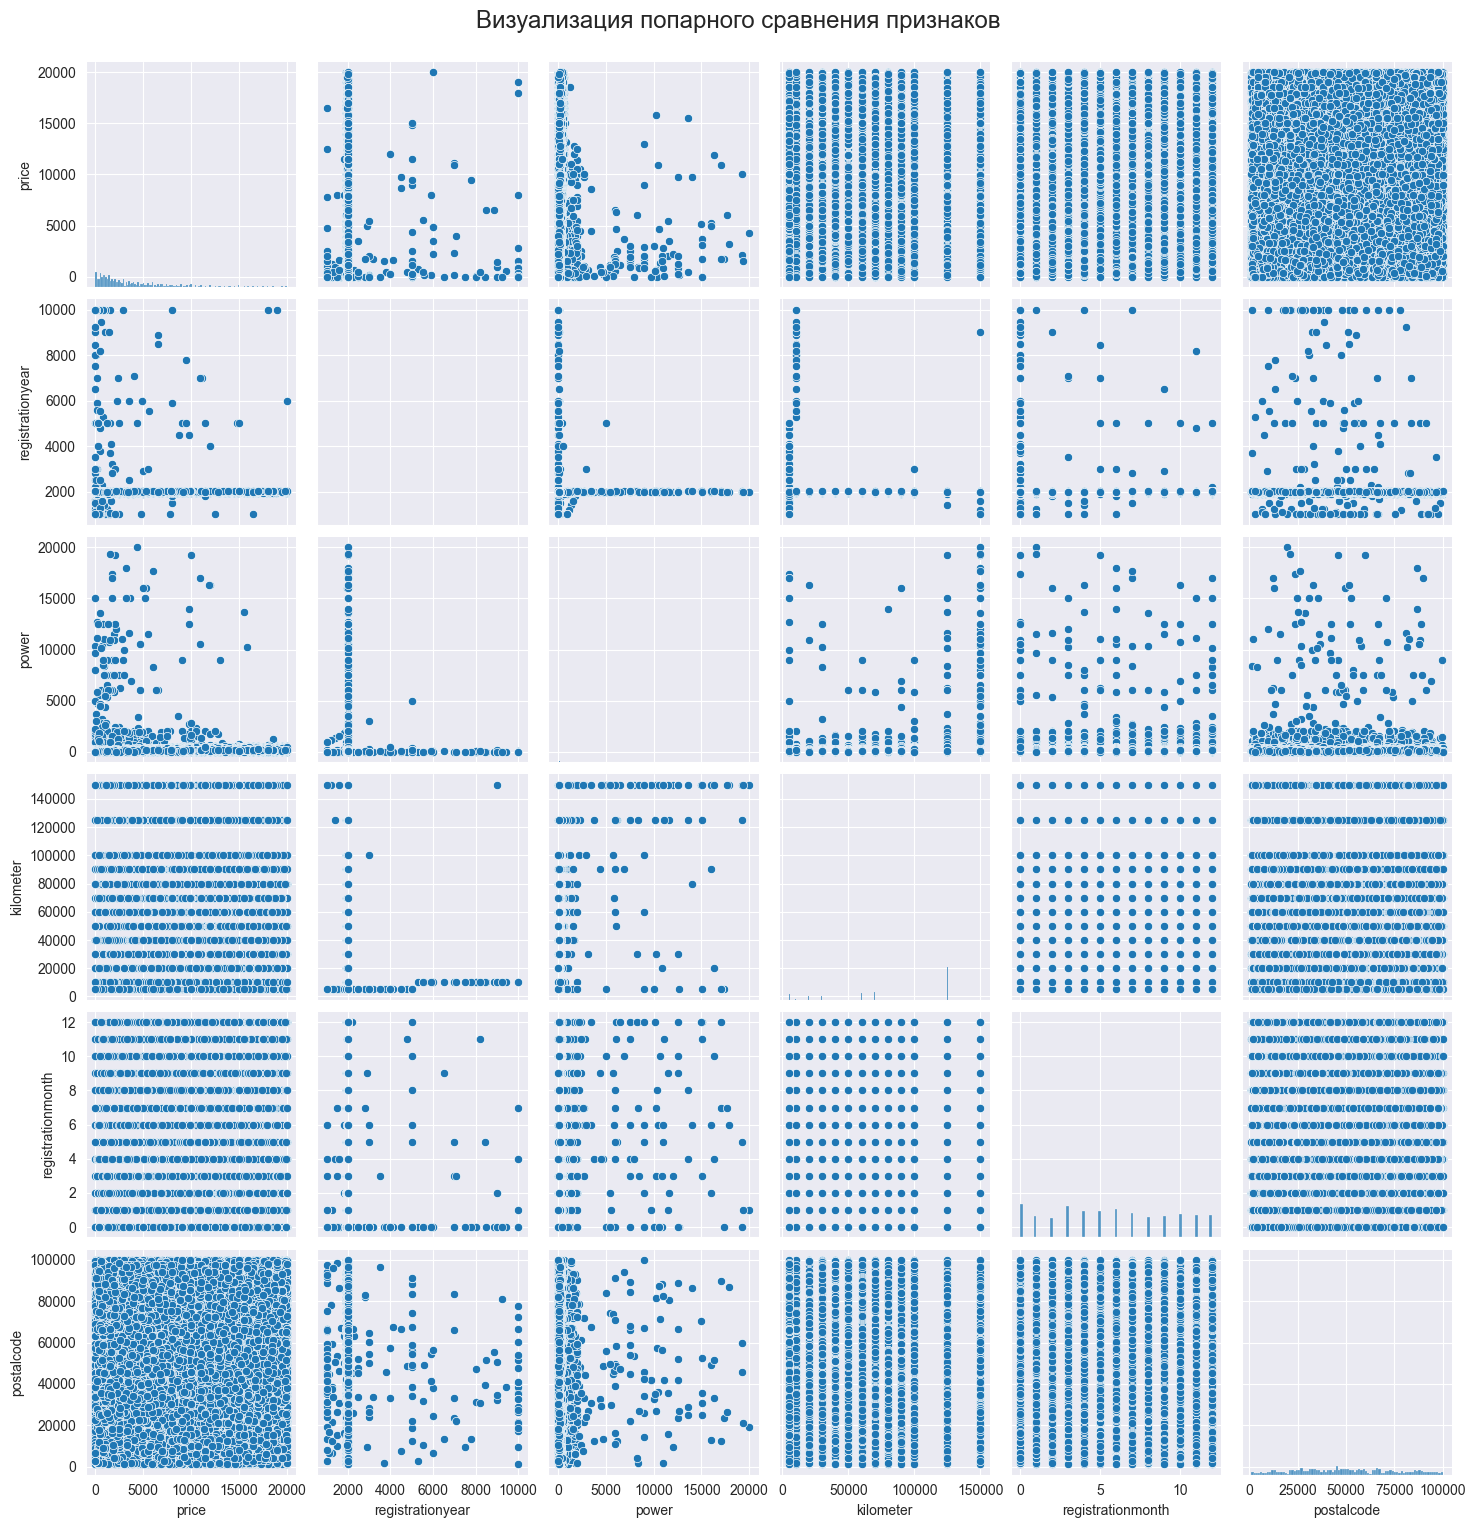

In [31]:
# Выявление распределений и взаимосвязей
sns.pairplot(data)
plt.suptitle('Визуализация попарного сравнения признаков', y=1.02, fontsize='xx-large');

In [ ]:
# Выявление признаков более сильно коррелирующих с целевым признаком:
sns.heatmap(data.select_dtypes(exclude='object').corr('spearman'), vmin=0, vmax=1, annot=True,linewidth=0.1, cmap='Oranges')
plt.title('Визуализация корреляции Спирмена', y=1, fontsize='x-large')
plt.xticks(roitation='45');

In [ ]:
# Информация о количестве автомобилей с мощностью двигателя менее 10 л.с.
data.loc[data['power'] <= 10]['brand'].value_counts()

In [27]:
# допущение об аномальности: мощность свыше 400 и менее 10 л.с. приравнивается к 0
data.loc[(data['power'] <= 10) | (data['power'] >= 400),'power'] = 0
# Замена мощности на медианное значение каждой модели в каждой марке
for i in data['brand'].unique():
    power_subs(i)

In [28]:
# Установка заглушек
data['gearbox'] = data['gearbox'].fillna('no_data')
data['fueltype'] = data['fueltype'].fillna('no_data')
data['vehicletype'] = data['vehicletype'].fillna('no_data')
data['model'] = data['model'].fillna('no_data')

# Удаление столбцов
data = data.drop(['datecrawled', 'registrationmonth', 'datecreated', 'lastseen'], axis=1)

# Обработка аномальных значений
data = data.query('price >=200')
data = data.query('1950 < registrationyear <= 2016')
data = data.query('brand != "sonstige_autos"').reset_index(drop=True)

In [29]:
# Уменьшение используемой памяти
cat_features = ['vehicletype', 'gearbox','model','fueltype','brand','repaired', 'kilometer']
memo_reductio(data, cat_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320638 entries, 0 to 320637
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             320638 non-null  int64  
 1   vehicletype       320638 non-null  object 
 2   registrationyear  320638 non-null  int64  
 3   gearbox           320638 non-null  object 
 4   power             320638 non-null  float64
 5   model             320638 non-null  object 
 6   kilometer         320638 non-null  int64  
 7   fueltype          320638 non-null  object 
 8   brand             320638 non-null  object 
 9   repaired          320638 non-null  object 
 10  postalcode        320638 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 126.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320638 entries, 0 to 320637
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   --

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,postalcode
0,480,no_data,1993,manual,101.0,golf,150000,petrol,volkswagen,no_data,70435
1,18300,coupe,2011,manual,190.0,no_data,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no_data,90480
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,60437
...,...,...,...,...,...,...,...,...,...,...,...
320633,3200,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes,96465
320634,1150,bus,2000,manual,125.0,zafira,150000,petrol,opel,no,26624
320635,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no,26135
320636,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no,87439


### Кодирование

In [30]:
# Разделение датасета на тренировочный и тестовый
features = data.drop('price', axis =1)
target = data['price']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            train_size=0.7,
                                                                            random_state=RS)
features_test, features_valid, target_test, target_valid = train_test_split(features_test, 
                                                                            target_test, 
                                                                            test_size=0.3, 
                                                                            random_state=RS)
# Кодирование номинативных переменных
ohe_encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
ohe_encoder.fit(features_train[cat_features])

features_train[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_train[cat_features])
features_train = features_train.drop(cat_features, axis=1)

features_test[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_test[cat_features])
features_test = features_test.drop(cat_features, axis=1)

features_valid[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_valid[cat_features])
features_valid = features_valid.drop(cat_features, axis=1)

In [31]:
# Трансформация числовых переменных
transformer = QuantileTransformer(output_distribution ='normal', random_state=RS)
features_train[['registrationyear', 'postalcode']] = transformer.fit_transform(features_train[['registrationyear', 'postalcode']]).astype('float32')
features_test[['registrationyear', 'postalcode']] = transformer.transform(features_test[['registrationyear', 'postalcode']])
features_valid[['registrationyear', 'postalcode']] = transformer.transform(features_valid[['registrationyear', 'postalcode']])

In [32]:
# Освобождение памяти
del data
del features
del target

cols_to_downgrade = features_train.select_dtypes(include='float64').columns.to_list()
features_train[cols_to_downgrade] = features_train[cols_to_downgrade].astype('float32')
features_test[cols_to_downgrade] = features_test[cols_to_downgrade].astype('float32')
features_valid[cols_to_downgrade] = features_valid[cols_to_downgrade].astype('float32')

### Предсказание и оценка

In [34]:
%%time
# LinearRegression обучение
regression.fit(features_train, target_train)

CPU times: total: 13.9 s
Wall time: 2.53 s


LinearRegression(n_jobs=-1)

In [35]:
%%time
# LinearRegression предсказание
predicted = regression.predict(features_test)
print(mean_squared_error(target_test, predicted, squared=False))

2569.411009610527
CPU times: total: 266 ms
Wall time: 93.7 ms


In [36]:
%%time
# DecisionTreeRegressor обучение
param_grid = {
    'max_depth':[None, 10, 50, 100, 500, 1000],
    'min_samples_split':[2, 10, 50, 100, 500, 1000],
    'min_samples_leaf':[1, 10, 50, 100, 500, 1000],
    'max_leaf_nodes':[1, 10, 50, 100, 500, 1000]
}
search = RandomizedSearchCV(tree, param_distributions=param_grid, n_jobs=-1, cv=5, random_state=RS)

search.fit(features_train, target_train)

CPU times: total: 1min 29s
Wall time: 1min 39s


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=888),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 50, 100, 500,
                                                      1000],
                                        'max_leaf_nodes': [1, 10, 50, 100, 500,
                                                           1000],
                                        'min_samples_leaf': [1, 10, 50, 100,
                                                             500, 1000],
                                        'min_samples_split': [2, 10, 50, 100,
                                                              500, 1000]},
                   random_state=888)

In [37]:
%%time
# DecisionTreeRegressor предсказание
predicted = search.predict(features_test)
print(mean_squared_error(target_test, predicted, squared=False))
print(search.best_estimator_)

1870.770880759143
DecisionTreeRegressor(max_depth=1000, max_leaf_nodes=1000,
                      min_samples_split=100, random_state=888)
CPU times: total: 172 ms
Wall time: 150 ms


In [38]:
%%time
# LightGBM обучение
param_grid = {
    'num_leaves':[n for n in range(10, 100, 10)], 
    'n_estimators':[n for n in range(10, 100, 10)],
    'min_data_in_leaf': [n for n in range(10, 100, 10)],
    'max_depth': [n for n in range(10, 100, 10)]
}

search = RandomizedSearchCV(light, param_distributions=param_grid, n_jobs=-1, cv=5, random_state=RS)

CPU times: total: 0 ns
Wall time: 0 ns


In [39]:
%%time
# LightGBM предсказание
search.fit(features_train, target_train)
predicted = search.predict(features_test)
print(mean_squared_error(target_test, predicted, squared=False))
print(search.best_estimator_)

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 224446, number of used features: 275
[LightGBM] [Info] Start training from score 4683.086600
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
1683.86629230603
LGBMRegressor(force_col_wise=True, max_depth=40, min_data_in_leaf=70,
              n_estimators=90, num_leaves=40, random_state=888)
CPU times: total: 1min 34s
Wall time: 1min 13s


### Вывод    
__Общий вывод:__
- В одном из двух признаков имеющих наиболее сильную корреляцию с целевым признаком проведена замена аномальных значений (до 10 и от 400 л.с.) на медианные значения для каждой модели у каждой марки авто.  
- Остальные столбцы обработаны так же, как в первой итерации (заглушки, удаление столбцов и т.п.)  
- К моделям решающего дерева и бустинга применен RandomizedSearch с кросс-валидацией. Осуществлен первичный перебор гиперпараметров.  

__Оценка:__
- RMSE модели линейной регрессии = 2569. 
- RMSE деревянной модели = 1870. 
- RMSE бустинговой модели = 1683.   
- Все модели улучшили показатели. По скорости бустинговая все так же уступает остальным.

***

# Итерация №3  
Обработка пропущенных значений в признаках

### Предобработка

In [40]:
#Обновление датасета
data = renew()
# Обязательные манипуляции
data['repaired'] = data['repaired'].fillna('no_data')
data = data.drop('numberofpictures', axis=1)

In [41]:
# Заполнение типа топлива
for i in data['brand'].unique():
    fueltype_fill(i)

# Присваивание категории 'no_data' отсутствующим значениям
data['fueltype'] = data['fueltype'].fillna('no_data')

In [42]:
# Заполнение типа кузова
for i in data['brand'].unique():
    vehicletype_fill(i)

# Присваивание категории 'no_data' отсутствующим значениям
data['vehicletype'] = data['vehicletype'].fillna('no_data')

In [43]:
# Заполнение типа коробки
# for i in data['brand'].unique():
#     gearbox_fill(i)
    
# Присваивание категории 'no_data' отсутствующим значениям
data['gearbox'] = data['gearbox'].fillna('no_data')

In [44]:
# Заполнение мощности
data.loc[(data['power'] <= 10) | (data['power'] >= 400),'power'] = 0
for i in data['brand'].unique():
    power_subs(i)

In [45]:
# Установка заглушек
data['gearbox'] = data['gearbox'].fillna('no_data')
data['model'] = data['model'].fillna('no_data')

# Удаление столбцов
data = data.drop(['datecrawled', 'registrationmonth', 'datecreated', 'lastseen'], axis=1)

# Обработка аномальных значений
data = data.query('price >=200')
data = data.query('1950 < registrationyear <= 2016')
data = data.query('brand != "sonstige_autos"').reset_index(drop=True)

### Кодирование

In [46]:
# Уменьшение используемой памяти
cat_features = ['vehicletype', 'gearbox','model','fueltype','brand','repaired', 'kilometer']
memo_reductio(data, cat_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320638 entries, 0 to 320637
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             320638 non-null  int64  
 1   vehicletype       320638 non-null  object 
 2   registrationyear  320638 non-null  int64  
 3   gearbox           320638 non-null  object 
 4   power             320638 non-null  float64
 5   model             320638 non-null  object 
 6   kilometer         320638 non-null  int64  
 7   fueltype          320638 non-null  object 
 8   brand             320638 non-null  object 
 9   repaired          320638 non-null  object 
 10  postalcode        320638 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 126.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320638 entries, 0 to 320637
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   --

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,postalcode
0,480,wagon,1993,manual,101.0,golf,150000,petrol,volkswagen,no_data,70435
1,18300,coupe,2011,manual,190.0,no_data,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no_data,90480
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,60437
...,...,...,...,...,...,...,...,...,...,...,...
320633,3200,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes,96465
320634,1150,bus,2000,manual,125.0,zafira,150000,petrol,opel,no,26624
320635,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no,26135
320636,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no,87439


In [47]:
# Разделение датасета на тренировочный и тестовый
features = data.drop('price', axis =1)
target = data['price']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            train_size=0.7,
                                                                            random_state=RS)
features_test, features_valid, target_test, target_valid = train_test_split(features_test, 
                                                                            target_test, 
                                                                            test_size=0.3, 
                                                                            random_state=RS)

# Кодирование номинативных переменных
ohe_encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
ohe_encoder.fit(features_train[cat_features])

features_train[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_train[cat_features])
features_train = features_train.drop(cat_features, axis=1)

features_test[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_test[cat_features])
features_test = features_test.drop(cat_features, axis=1)

features_valid[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(features_valid[cat_features])
features_valid = features_valid.drop(cat_features, axis=1)

In [48]:
# Трансформация числовых переменных
transformer = QuantileTransformer(output_distribution ='normal', random_state=RS)
features_train[['registrationyear', 'postalcode']] = transformer.fit_transform(features_train[['registrationyear', 'postalcode']])
features_test[['registrationyear', 'postalcode']] = transformer.transform(features_test[['registrationyear', 'postalcode']])
features_valid[['registrationyear', 'postalcode']] = transformer.transform(features_valid[['registrationyear', 'postalcode']])

In [49]:
# Освобождение памяти
del features
del target

cols_to_downgrade = features_train.select_dtypes(include='float64').columns.to_list()
features_train[cols_to_downgrade] = features_train[cols_to_downgrade].astype('float32')
features_test[cols_to_downgrade] = features_test[cols_to_downgrade].astype('float32')
features_valid[cols_to_downgrade] = features_valid[cols_to_downgrade].astype('float32')

### Предсказание и оценка

In [51]:
%%time
# LinearRegression обучение
regression.fit(features_train, target_train) 

CPU times: total: 13.7 s
Wall time: 2.53 s


LinearRegression(n_jobs=-1)

In [52]:
%%time
# LinearRegression предсказание
predicted = regression.predict(features_test)
print(mean_squared_error(target_test, predicted, squared=False))

2619.625
CPU times: total: 219 ms
Wall time: 53.9 ms


In [53]:
%%time
# DecisionTreeRegressor обучение
param_grid = {
    'max_depth':[1050, 1100, 1200, 1250, 1300, 1400, 1450],
    'max_leaf_nodes':[1000, 1400, 1500, 1600, 2000],
    'min_samples_split':[105, 110, 120, 125, 130, 140, 145],
    'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9],
}

search = RandomizedSearchCV(tree, param_distributions=param_grid, n_jobs=-1, cv=5, random_state=RS)

search.fit(features_train, target_train)

CPU times: total: 2min 25s
Wall time: 2min 57s


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=888),
                   n_jobs=-1,
                   param_distributions={'max_depth': [1050, 1100, 1200, 1250,
                                                      1300, 1400, 1450],
                                        'max_leaf_nodes': [1000, 1400, 1500,
                                                           1600, 2000],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [105, 110, 120,
                                                              125, 130, 140,
                                                              145]},
                   random_state=888)

In [54]:
%%time
# DecisionTreeRegressor предсказание
predicted = search.predict(features_test)
print(mean_squared_error(target_test, predicted, squared=False))
print(search.best_estimator_)

1808.053845121285
DecisionTreeRegressor(max_depth=1200, max_leaf_nodes=2000, min_samples_leaf=5,
                      min_samples_split=125, random_state=888)
CPU times: total: 78.1 ms
Wall time: 70.8 ms


In [55]:
%%time
# LightGBM обучение
param_grid = {
    'num_leaves':[25,35,40,45,55], 
    'n_estimators':[75,85,90,95,105],
    'min_data_in_leaf':[55,65,70,75,85],
    'max_depth':[25,35,40,45,55]
}

search = RandomizedSearchCV(light, param_distributions=param_grid, n_jobs=-1, cv=5, random_state=RS)

CPU times: total: 0 ns
Wall time: 0 ns


In [56]:
%%time
# LightGBM предсказание
search.fit(features_train, target_train)
predicted = search.predict(features_test)
print(mean_squared_error(target_test, predicted, squared=False))
print(search.best_estimator_)

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 224446, number of used features: 279
[LightGBM] [Info] Start training from score 4683.086600
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
1663.2755038602702
LGBMRegressor(force_col_wise=True, max_depth=45, min_data_in_leaf=65,
              n_estimators=95, num_leaves=55, random_state=888)
CPU times: total: 1min 33s
Wall time: 1min 16s


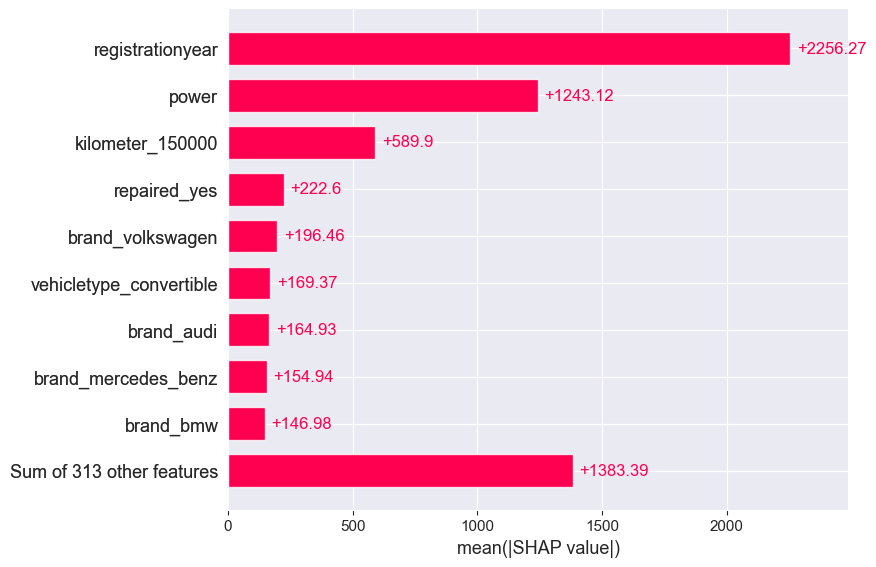

In [57]:
# Оценка влияния признаков на предсказание
explainer = shap.Explainer(search.best_estimator_)
shap_values = explainer(features_train)
shap.plots.bar(shap_values)

### Вывод:   

__Общий вывод:__      
- Рассмотрены пропущенные значения признаков: Тип топлива, Тип кузова, Тип коробки передач.  
- Тип коробки передач убран из финального варианта, т.к. отрицательно влиял на метрику.
- Пропущенные значения заполнены наиболее часто встречающимся значением каждого бренда/марки.
- Добавлен признак из Итерации 2 (мощность)
- Внесены изменения в гиперпараметры моделей бустинга и решающего дерева (учтен эффект влияния на метрику с гиперпараметрами  из Итерации 2)  
- Для дальнейшего исследования приготится понимание вклада параметров в резульатат: наибольший вклад вносит год регистрации и мощность.
  
__Оценка:__  

- RMSE модели линейной регрессии = 2619.
- RMSE деревянной модели = 1808. 
- RMSE бустинговой модели = 1663. 
- Метрики улучшены. Скорость предсказания увеличена. Для небольшого датасета вполне терпима бустинговая модель, т.к. выдает лучший вариант предсказания, несмотря на худшие показатели в скорости.

***

# Проверка лучшей модели на валидационной выборке

In [58]:
%%time
# LightGBM предсказание
predicted = search.predict(features_valid)
print(mean_squared_error(target_valid, predicted, squared=False))
print(search.best_estimator_)

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
1617.2998726825494
LGBMRegressor(force_col_wise=True, max_depth=45, min_data_in_leaf=65,
              n_estimators=95, num_leaves=55, random_state=888)
CPU times: total: 422 ms
Wall time: 113 ms


# Финальный вывод    
__Общий вывод:__
- Рассмотрено три модели:  
    - LinearRegression  
    - DeccisionTreeClassifier
    - LightGBM  
- Все модели, кроме LinearRegression перешли заданный порог - ниже 2500 по предсказанию.
- Время обучения и предсказания ожидаемо увеличивается с увеличением количества перебираемых гиперпараметров  
- Наиболее сильное влияение на результат предсказание оказывают признаки Год регистрации и Мощность двигателя.  
- Для ускорения вычислений были применены техники уменьшения объема памяти датасета и RandomizedSearchCV  
- На валидационной выборке лучшая модель показала 1617

__Рекомендации:__    
- Время обучения модели: самое лучшее у LightGBM, учитывая перебор гиперпараметров
- Время предсказания модели: самое короткое - LinearRegression
- Качество предсказания модели:  LightGBM предсказывает точнее ближайшего конкурента.  

Рекомендовано исполььзовать модель LightGBM, как наиболее быструю и точную модель.
